In [1]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv('downloads/mt/EURUSD_H1_201401012300_202408261800.csv', sep="\\t")
df['Gmt time'] = df['<DATE>'] + ' ' + df['<TIME>']


df.rename(columns={'<CLOSE>' : 'Close', '<HIGH>': 'High', '<OPEN>' : 'Open', '<LOW>':'Low'}, inplace=True)
# df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%Y.%m.%d %H:%M:%S')
df.drop(columns =['<DATE>', '<TIME>'], inplace=True)
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)
df.drop(columns=['<TICKVOL>', '<SPREAD>', '<VOL>'], inplace=True)

C:\Users\S.Eyvazi\AppData\Local\Temp\ipykernel_2948\3764333000.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('downloads/mt/EURUSD_H1_201401012300_202408261800.csv', sep="\\t")


In [2]:
def feature_engineering(df : pd.DataFrame, i : int, n :int):
        
    ema_50 = ta.ema(df.Close, length=50)
    ema_30 = ta.ema(df.Close, length=30)
    rsi_14 = ta.rsi(df.Close, length=14)
    cci = ta.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    my_bbands = ta.bbands(df.Close, length=15, std=1.5)
    atr_10 = ta.atr(df.High, df.Low, df.Close, length=10)
            
    df = df.join(ema_50)
    df = df.join(ema_30)
    df = df.join(rsi_14)
    df = df.join(atr_10)
    df = df.join(cci)
    df = df.join(my_bbands)
        
    # Adding Simple Moving Averages
    df['sma5'] = ta.sma(df['Close'],window = 5)
    df['sma10'] = ta.sma(df['Close'],window = 10)
    df['sma15'] = ta.sma(df['Close'],window = 15)
    df['sma20'] = ta.sma(df['Close'],window = 20)
    df['sma30'] = ta.sma(df['Close'],window = 30)
    df['sma50'] = ta.sma(df.Close,length=50)
    df['sma80'] = ta.sma(df['Close'],window = 80)
    df['sma100'] = ta.sma(df['Close'],window = 100)
    df['sma200'] = ta.sma(df['Close'],window = 200)

    # Adding Price to Simple Moving Averages ratios

    df['sma5_ratio'] = df['Close'] / df['sma5']
    df['sma10_ratio'] = df['Close'] / df['sma10']
    df['sma20_ratio'] = df['Close'] / df['sma20']
    df['sma30_ratio'] = df['Close'] / df['sma30']
    df['sma50_ratio'] = df['Close'] / df['sma50']
    df['sma80_ratio'] = df['Close'] / df['sma80']
    df['sma100_ratio'] = df['Close'] / df['sma100']
    df['sma200_ratio'] = df['Close'] / df['sma200']

    # Adding RSI, CCI, Bollinger Bands, and OBV

    df['rsi'] = ta.rsi(df['Close'],length=14)
    df['cci'] = ta.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.bbands(df['Close'], length=20, std=2)
    
    df=df.join(bb_indicator)

    # Adding features derived from the indicators above

    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['above_bb_high'] = (df['Close'] >= df['BBU_20_2.0']).astype(int)
    df['below_bb_low'] = (df['Close'] <= df['BBL_20_2.0']).astype(int)
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int)
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int)
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int)
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int)
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int)
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int)
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)

    df['close_above_bbl_15_1.5'] = (df['Close'] >= df['BBL_15_1.5']).astype(int)
    df['close_above_bbl_20_2'] = (df['Close'] >= df['BBL_20_2.0']).astype(int)

    df['close_bellow_bbu_15_1.5'] = (df['Close'] >= df['BBU_15_1.5']).astype(int)
        
    # Removing NaN values from the dataframe 
    df.dropna(inplace = True)
    return df

n = 10**3
df_list = [ feature_engineering(df[i:i+n], i, i+n) for i in range(0, df.shape[0], n)]

df = pd.concat(df_list)


In [3]:
df['prev_fast_sma'] = df['sma30'].shift(1)


In [4]:
from tqdm import tqdm
import numpy as np

def find_crossover(fast_sma, prev_fast_sma, slow_sma):

    if fast_sma > slow_sma and prev_fast_sma < slow_sma:
        return 1
    elif fast_sma < slow_sma and prev_fast_sma > slow_sma:
        return 2

    return 0


tqdm.pandas()
df.reset_index(inplace=True)


df['crossover'] = np.vectorize(find_crossover)(df['sma15'], df['prev_fast_sma'], df['sma50'])


E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2480: RuntimeWarning: invalid value encountered in find_crossover (vectorized)
  outputs = ufunc(*inputs)


In [5]:
df.reset_index(drop=True, inplace=True)
df.set_index('Gmt time', inplace=True)

In [6]:
import numpy as np

df['NextClose'] = df['Close'].shift(-1) - df['Close']
df['close_after_5_days'] = df['Close'].diff().rolling(5).sum()
df['close_after_10_days'] = df['Close'].diff().rolling(10).sum()

conditions = [df['close_after_5_days'] <= 0, df['close_after_5_days'] > 0 ]
choices = [0, 1]
df['Target'] = np.select(conditions, choices)


df['Target2'] = np.where(df['close_after_10_days'] <= 0, 0, 1)


In [22]:
# import quantstats as qs

# Machine Learning 
from sklearn.metrics import roc_auc_score
import logging, sys
logging.disable(sys.maxsize)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

df.dropna(inplace=True)
target = df['Target']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'NextClose', 'close_after_5_days','close_after_10_days'], axis=1), target, test_size=.3)

sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

classifiers = [
    XGBClassifier(random_state = 42),
    LGBMClassifier(random_state = 42),
    AdaBoostClassifier(random_state = 42, n_estimators=45),
    RandomForestClassifier(random_state = 42, max_depth=30,min_samples_leaf=20, n_estimators=7)
]

#  Iterating over classifiers in the list above, training, and evaluating them
k_folds = KFold(n_splits = 5)

for clf in classifiers:
    scores = cross_val_score(clf, X_train_scaled, y_train, cv = k_folds)
    
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_test_scaled)
    print(f'{type(clf).__name__}: Accuracy Score={accuracy_score(y_test, y_pred):.6f}')
    print(f'{type(clf).__name__}: Mean KFold={scores.mean():.6f}')
    print(f'{type(clf).__name__}: Max KFold={scores.max():.6f}')


XGBClassifier: Accuracy Score=0.866426
XGBClassifier: Mean KFold=0.869203
XGBClassifier: Max KFold=0.873707
[LightGBM] [Info] Number of positive: 17566, number of negative: 17621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9970
[LightGBM] [Info] Number of data points in the train set: 35187, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499218 -> initscore=-0.003126
[LightGBM] [Info] Start training from score -0.003126
[LightGBM] [Info] Number of positive: 17537, number of negative: 17650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9970
[LightGBM] [Info] Number of data points in the train set: 35187, number of used features: 51
[LightGBM] [Info] [binary:BoostFromSco

<Axes: >

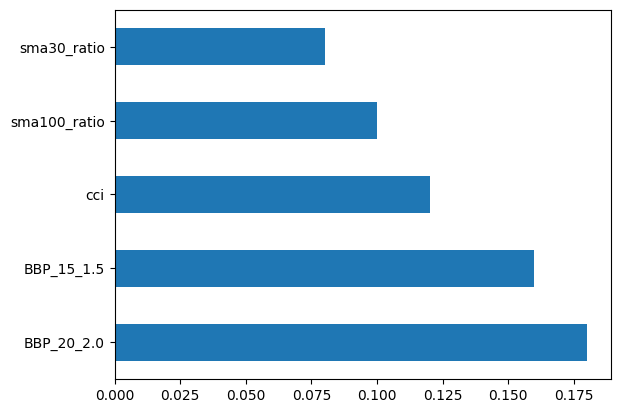

In [95]:
(pd.Series(classifiers[2].feature_importances_, index=df.drop(columns=['Target', 'Target2', 'close_after_10_days', 'NextClose', 'close_after_5_days'], axis=1).columns).nlargest(5).plot(kind='barh'))

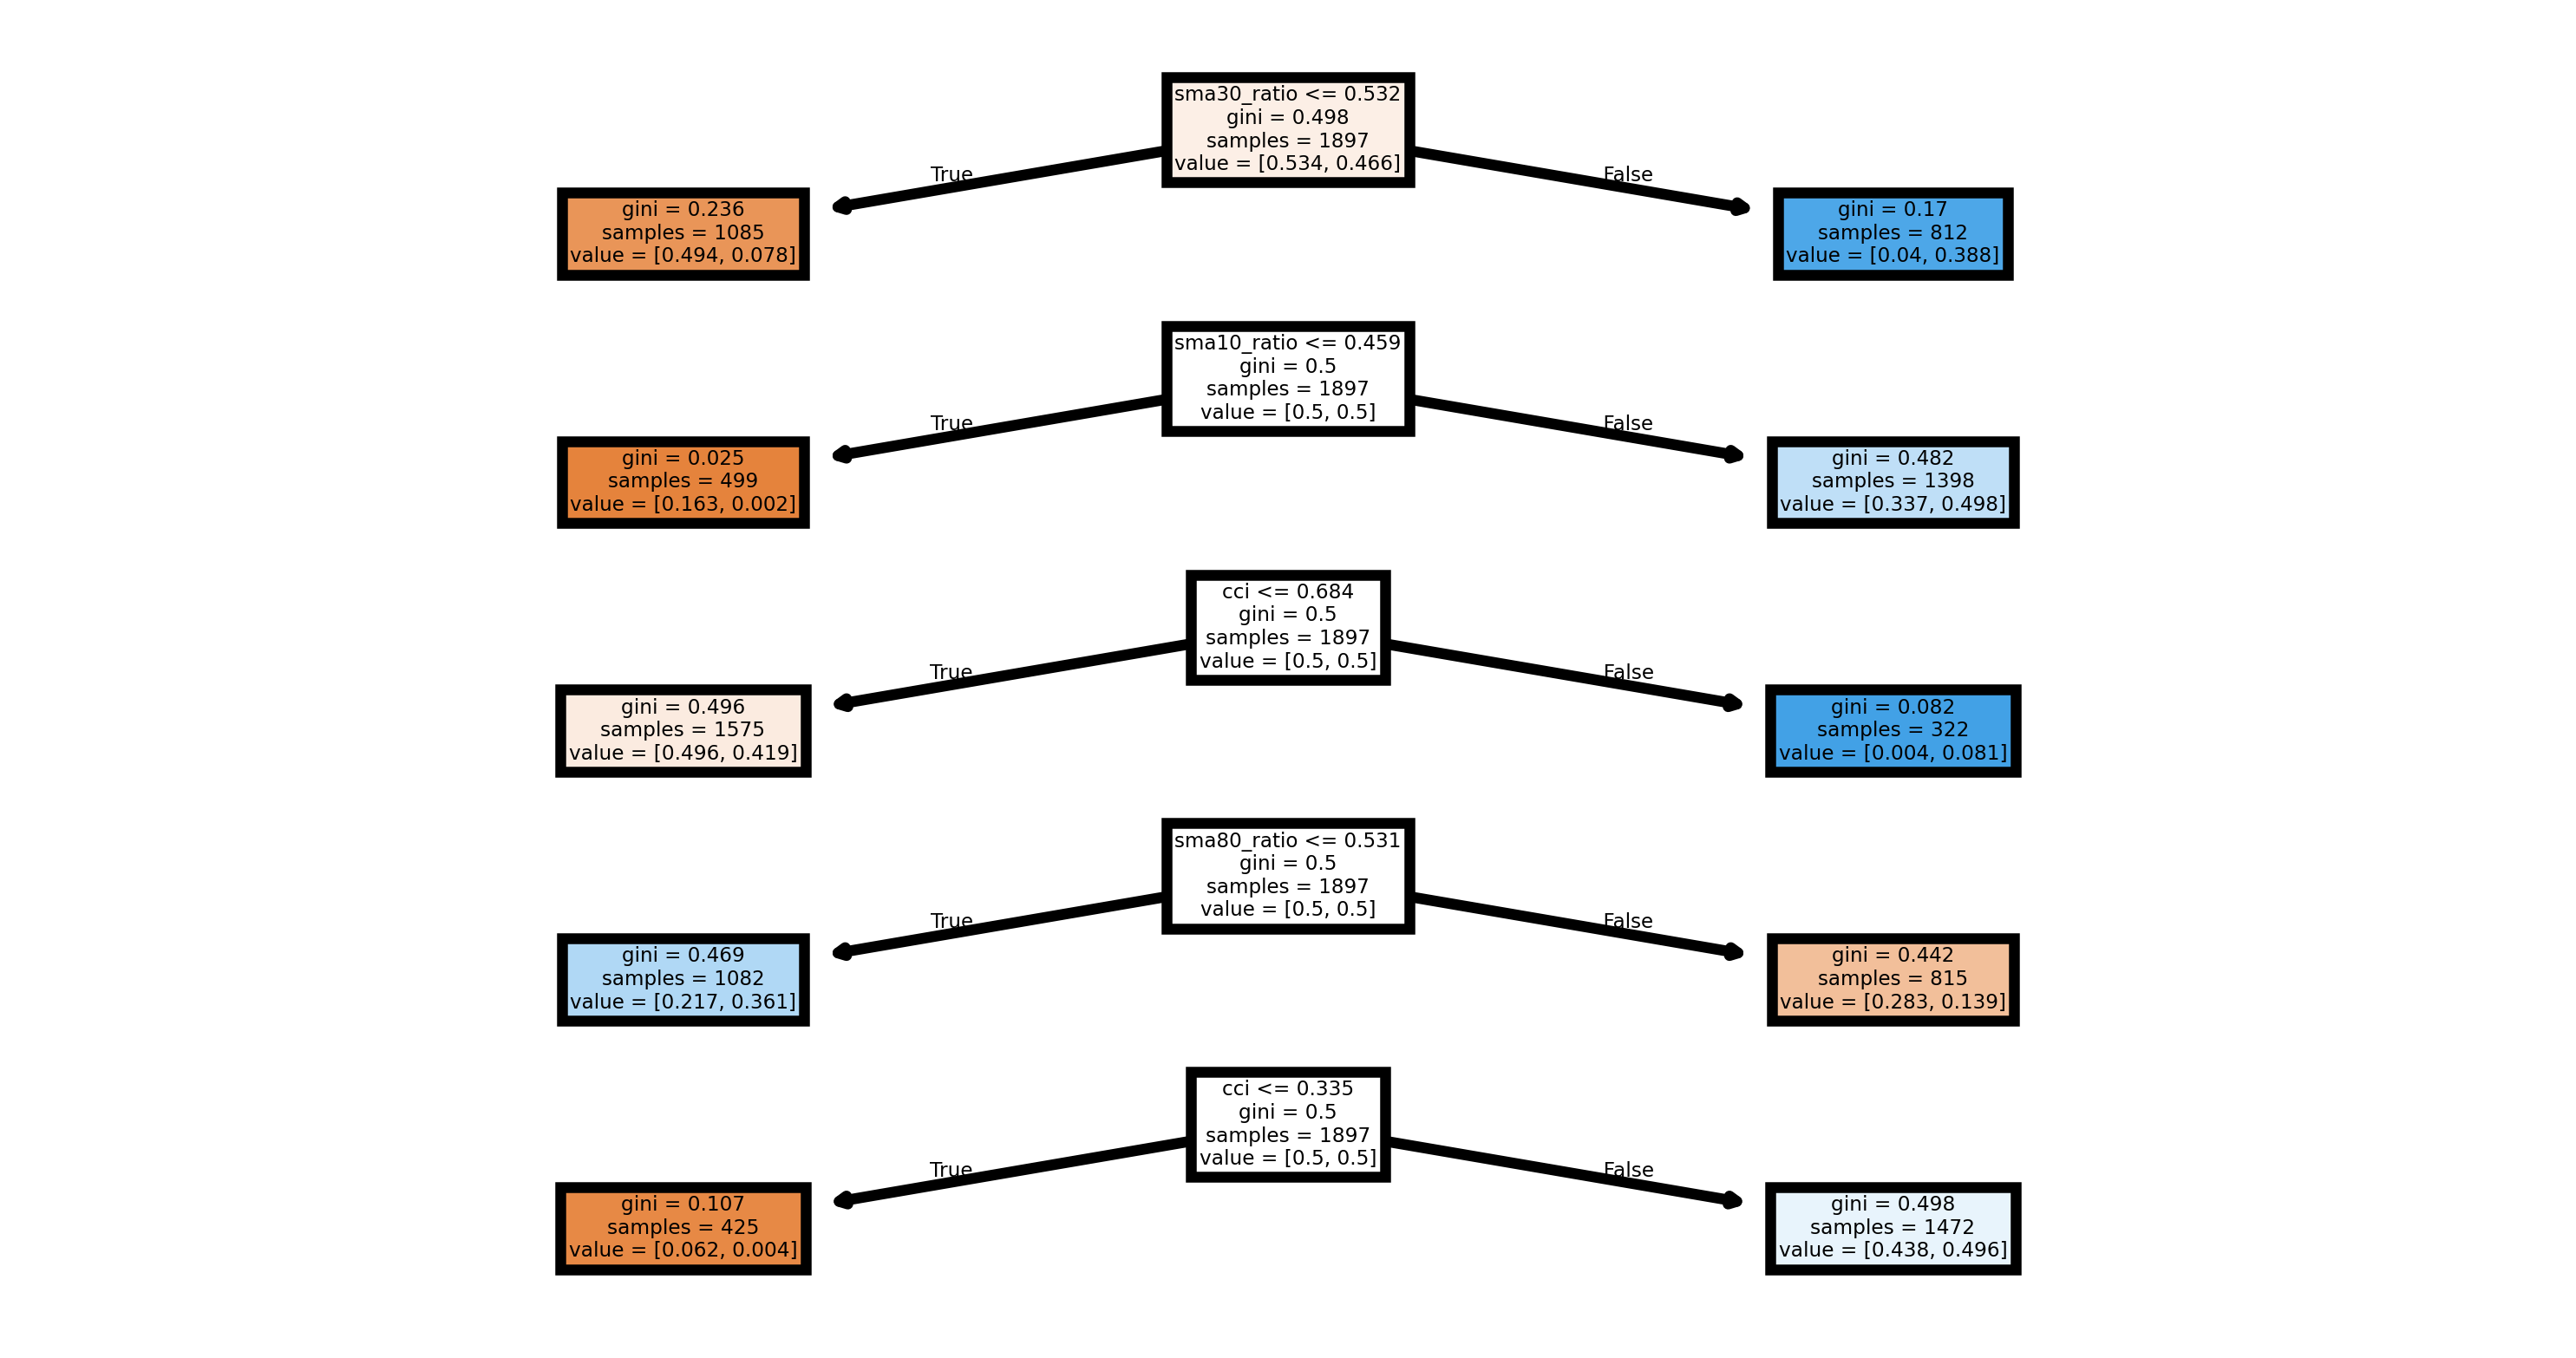

In [39]:
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline
fn=df.drop(columns=['Target', 'NextClose'], axis=1).columns
cn=['Target']

fig, axes = plt.subplots(nrows = 5,ncols = 1,figsize = (4,2), dpi=900)


for item in range(0,5):
    tree.plot_tree(classifiers[2].estimators_[item],
                   feature_names = fn,filled = True,ax = axes[item]);



# Hyperparamter Tuning For AdaBoost Classifier

In [33]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
target = df['Target']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'NextClose', 'close_after_5_days','close_after_10_days'], axis=1), target, test_size=.3)


sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from utils.lwoku import RANDOM_STATE, N_JOBS, VERBOSE, get_prediction
from utils.grid_search_utils import plot_grid_search, table_grid_search

import pickle
ab_clf = AdaBoostClassifier(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': [15, 20, 30, 40, 45, 50],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']
}
clf = GridSearchCV(ab_clf, parameters, verbose=VERBOSE, n_jobs=N_JOBS)
clf.fit(X_train_scaled, y_train)

plot_grid_search(clf)
table_grid_search(clf)

with open('adaboost.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

,mean_test_score,mean_fit_time,mean_score_time,param_algorithm,param_learning_rate,param_n_estimators
88,0.864746,13.341375,0.122559,SAMME.R,1.03,45


AdaBoostClassifier(learning_rate=1.03, n_estimators=45, random_state=42)

### Hyper Parameter RandomForest Classifier

In [26]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
target = df['Target']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'NextClose', 'close_after_5_days','close_after_10_days'], axis=1), target, test_size=.3)


sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from utils.lwoku import RANDOM_STATE, N_JOBS, VERBOSE, get_prediction
from utils.grid_search_utils import plot_grid_search, table_grid_search

import pickle
ab_clf = RandomForestClassifier(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': [20, 30, 40, 45, 50],
    'max_depth' : [20,30,40,50],
    'min_samples_split':[30,40,50,60, 80,100]
}
clf = GridSearchCV(ab_clf, parameters, verbose=VERBOSE, n_jobs=N_JOBS)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print("acc score : ", accuracy_score(y_test, y_pred))
plot_grid_search(clf)
table_grid_search(clf)

with open('randomforest.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

acc score :  0.8705638958145456


,mean_test_score,mean_fit_time,mean_score_time,param_max_depth,param_min_samples_split,param_n_estimators
21,0.870089,7.716452,0.038412,20,50,40
